# PyTorch with The Fashion MINST Dataset (Simple Project)

This notebook contains the steps for building deep neural network using PyTorch and the fashion Minst dataset where it takes an image of clothes as input and predict its class. Then, it shows the impacts of varying the hyperparameters on the accuracy of the prediction model.

## Table of Contents
#####  First Training 
  - Import The Relevant Packages
  - Download and Prepare The Dataset
  - Build a Class to Fetch The Dataset
  - Define The Model, Loss Function, and Optimizer
  - Define a Training Function
  - Define an Evaluation Funtion
  - Train the Network
  - Display the Variation of the Training Loss and Accuracy
  - Results and Conclusion
##### The impact of scaling the dataset
##### The impact of varing the batch size


## First Training

### 1.1 Import The Relevant Packages

In [107]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on cuda if GPU is available

### 1.2 Download and Prepare The Dataset

In [108]:
from torchvision import datasets
data_folder = ".\Datasets\FMNIST"                         #can be any directory to download the dataset
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [109]:
train_images = fmnist.data                                #training images 
train_targets = fmnist.targets                            #images labels (classes)

In [110]:
print(f"Number of training images {train_images.shape[0]}")
print(f"Number of classess {len(train_targets.unique())}")
print(f"The classess {fmnist.classes}")

Number of training images 60000
Number of classess 10
The classess ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


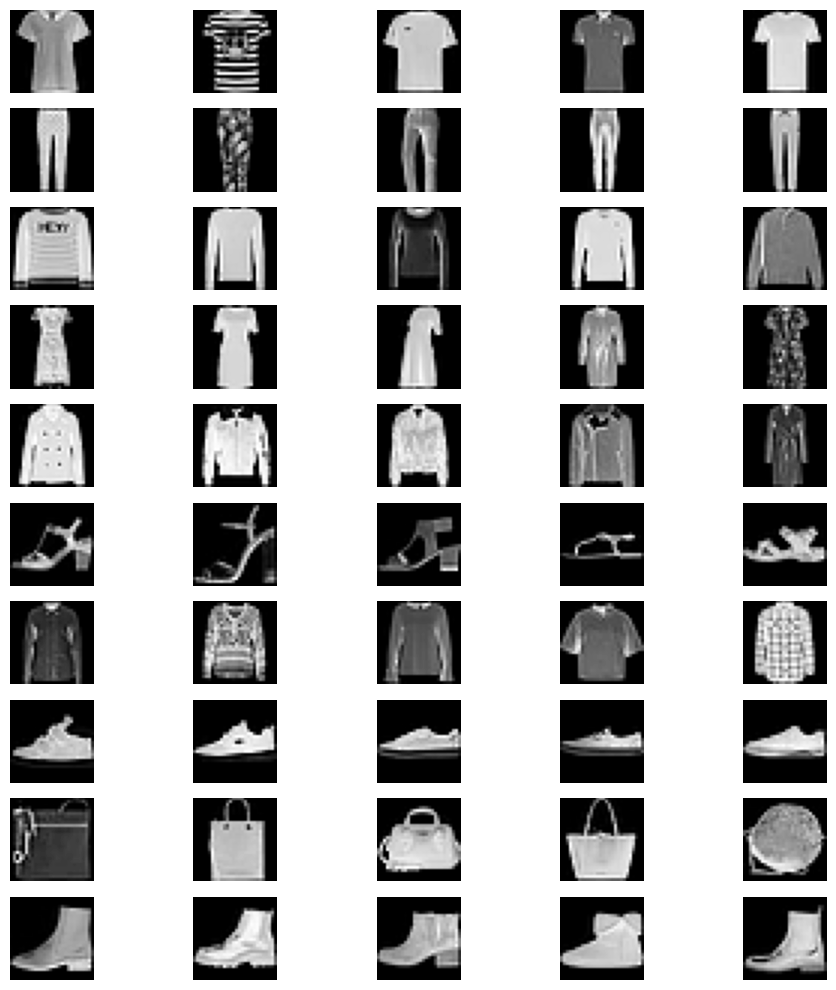

In [111]:
#Create a plot of 10*5 grid where each row belongs to a class to visualize the dataset
row,col = len(train_targets.unique()) , 5
fig, ax = plt.subplots(row,col, figsize = (10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_targets == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x= train_images[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

### 1.3 Build a Class to Fetch The Dataset

In [112]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x= x.float()                #convert the images to a float point numbers
        x = x.view(-1,28*28)        #flatten each image
        self.x , self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        x,y = self.x[index], self.y[index]
        return x.to(device), y.to(device)       #resgister the input and the output data to the device "cuda" to train on GPU

In [113]:
train_data = FMNISTDataset(train_images,train_targets) 
#use Dataloader to sample 32 data points randomly for each batch size
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True) 

### 1.4 Define The Model, Loss Function, and Optimizer

In [114]:
#Create a model with one hidden layer (1000 neurons) and the output is a 10-neuron layer to predict the 10 classess
def build_model():
    
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000,10)
                         ).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 1e-2)   #initialize the learning rate to 0.01
    
    return model , loss_function, optimizer


### 1.5 Define a Training Function

In [115]:
def train_batch(input_batch, targets, model, loss_function, optimizer):
    model.train()                                        
    predictions = model(input_batch)                     #perfom forward propagation
    batch_loss = loss_function(predictions,targets)      #compute the loss value 
    batch_loss.backward()                                #perfom backward propagation
    optimizer.step()                                     #calculate new weights
    optimizer.zero_grad()                                #flush the gradients for next batch of calculations
    
    return batch_loss.item()                             #return the loss value
      

### 1.6 Define an Evaluation Funtion 

In [116]:
@torch.no_grad()                       #disable the gradients calculation
def get_accuracy(input_batch, targets, model):
    model.eval()
    predictions = model(input_batch)              #perfom forward propagation
    max_values, argmaxes = predictions.max(-1)    #get argmax index for each row
    is_correct = argmaxes ==targets               #compare argmax with tragets to check that each row predicts correctly
    
    return is_correct.cpu().numpy().tolist()      #return the result,register it to the cpu, and convert it to numpy array

### 1.7 Train the Network

In [117]:
model,loss_function, optimizer = build_model()
def train(epoch_number):
    losses, accuracies = [], []                      # define lists to contain the loss and accuracy values of each epoch
    for epoch in range (epoch_number):               #define the number of the epochs
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       #define lists to contain the loss and accuracy values of each batch

        for batch in (iter(train_data_loader)):      #create batches of training data by iterating thorugh data loader
            input_batch, targets = batch                     #unpack the batch 
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  #train the batch

            batch_losses.append(batch_loss)                               #store the loss value of each batch
        epoch_loss = np.array(batch_losses).mean()                        #get the mean of the loss values of all batches
        losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        print('<--------------------------------------------------------->')
        
    return losses, accuracies

lossses, accuracies = train(10)

Epoch: 1
Train Loss: 30.132
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 2.219
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 2.201
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 2.181
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 2.181
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 2.244
Train Accuracy: 12%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 2.242
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 8
Train Loss: 2.207
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 9
Train Loss: 2.181
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 10
Train Loss: 2.198
Train Ac

### 1.8 Display the Variation of the Training Loss and Accuracy

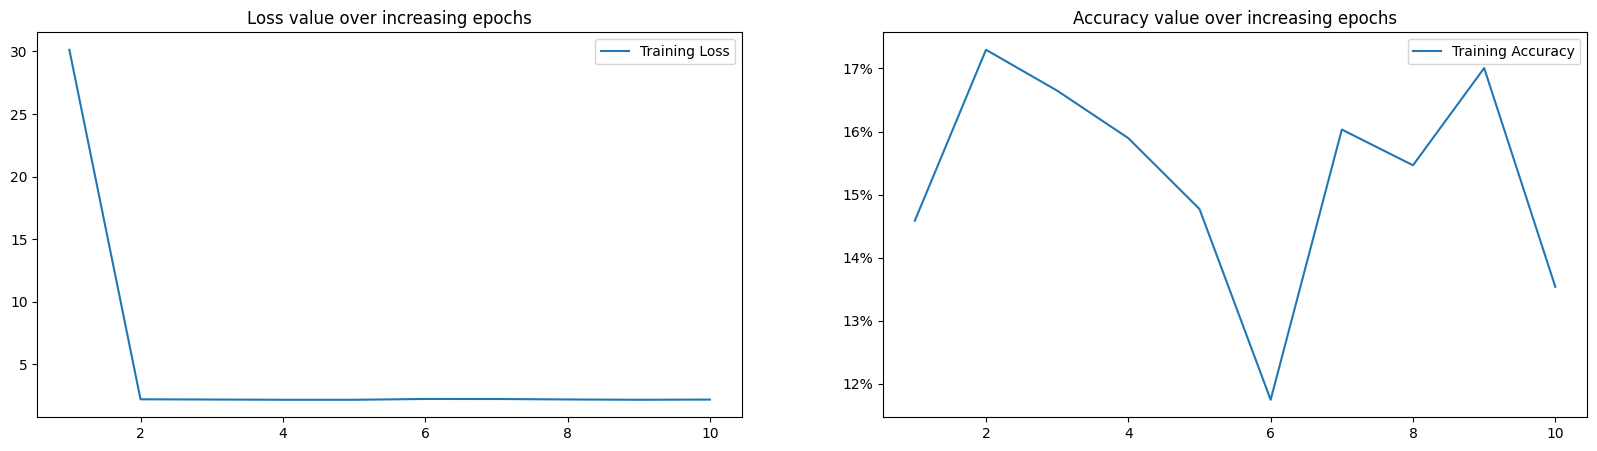

In [118]:
def display_loss_accuracy(number_epoch,lossses, accuracies):
    epochs = np.arange(number_epoch)+1
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Loss value over increasing epochs')
    plt.plot(epochs, lossses, label='Training Loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Accuracy value over increasing epochs')
    plt.plot(epochs, accuracies, label='Training Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()

display_loss_accuracy(10,lossses, accuracies)

### 1.9 Results and Conclusion

 1. The training accuracy is not good enough at the end of ten epochs
 2. The loss value did not decrease considerably over the increasing numbers of epochs
 
 ##### so we will try to change the hyperparameters to see their impact on the training accuarcy and the loss value 

## The impact of Scaling the Dataset

The only change here is to modify the FMNISTDataset class where the input value is divided by the maximum possible value in the dataset which is 255. This to ensure that all the variables values are between 0 and 1.

In [119]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x= x.float()/255            #divide the input data by the maximum value
        x = x.view(-1,28*28)        
        self.x , self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        x,y = self.x[index], self.y[index]
        return x.to(device), y.to(device)       

In [120]:
train_data = FMNISTDataset(train_images,train_targets) 
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [121]:
model,loss_function, optimizer = build_model()
lossses, accuracies = train(10)

Epoch: 1
Train Loss: 0.844
Train Accuracy: 80%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.536
Train Accuracy: 82%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.481
Train Accuracy: 84%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.454
Train Accuracy: 84%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.433
Train Accuracy: 86%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.419
Train Accuracy: 86%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.406
Train Accuracy: 87%
<--------------------------------------------------------->
Epoch: 8
Train Loss: 0.394
Train Accuracy: 87%
<--------------------------------------------------------->
Epoch: 9
Train Loss: 0.384
Train Accuracy: 87%
<--------------------------------------------------------->
Epoch: 10
Train Loss: 0.375
Train Acc

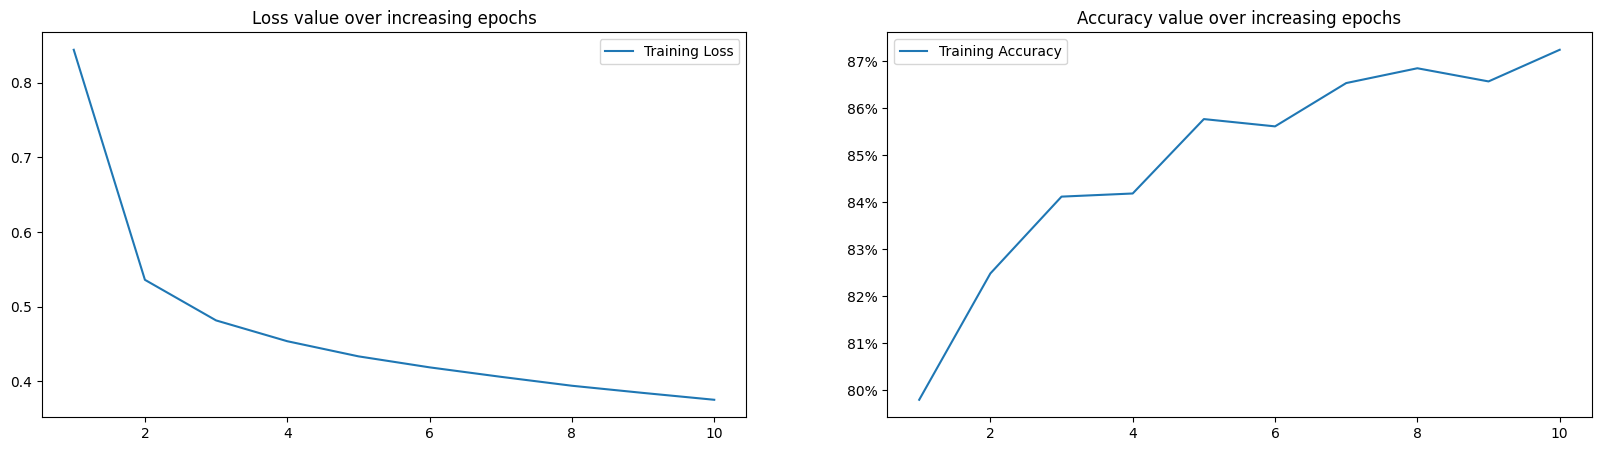

In [122]:
display_loss_accuracy(10,lossses, accuracies)

Scaling the input dataset so that it contains a much smaller range of values generally helps in achieving better model accuracy.

## The Impact of Varing the Batch Size

The change here is we will rerun the code to generate the validation dataset and change the batch size from 32 to 10,000 to see the impact on the loss value and prediction model accuracy.

In [123]:
data_folder = ".\Datasets\FMNIST"                         
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
train_images = fmnist.data                                
train_targets = fmnist.targets                           

In similar mannaer download and import the validation dataset by specifiying: 
#### Train = False

In [124]:
validation_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
validation_images = validation_fmnist.data                                
validation_targets = validation_fmnist.targets  

In [125]:
def get_data(batchsize):
    train_data = FMNISTDataset(train_images,train_targets) 
    train_data_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True) 
    validation_data = FMNISTDataset(validation_images,validation_targets) 
    validation_data_loader = DataLoader(validation_data, batch_size=len(validation_images), shuffle=False) 
    
    return train_data_loader, validation_data_loader


In [126]:
#define a function to calculate the loss value of the validation dataset
@torch.no_grad()
def get_validation_loss_value(input_batch, targets,model):
    model.eval()
    predictions = model(input_batch)
    validation_loss = loss_function(predictions,targets)
    
    return validation_loss.item() 

In [127]:
train_data_loader, validation_data_loader = get_data(32)

In [128]:
model,loss_function, optimizer = build_model()

In [129]:
def train_with_validation(epoch_number):
    train_losses, train_accuracies = [], []   
    validation_losses, validation_accuracies = [], [] 
    for epoch in range (epoch_number):               
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       

        for batch in (iter(train_data_loader)):      
            input_batch, targets = batch                     
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  

            batch_losses.append(batch_loss)                               
        epoch_loss = np.array(batch_losses).mean()                        
        train_losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        train_accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        
        for batch in (iter(validation_data_loader)):
            input_batch, targets = batch
            validation_loss_value = get_validation_loss_value(input_batch, targets, model)
            validation_accuracy = get_accuracy(input_batch, targets, model)
            
        validation_losses.append(validation_loss_value)
        print(f"Validation Loss: {validation_loss_value:0.3f}")
        valiation_epoch_accuracy = np.mean(validation_accuracy)
        print(f"Validation Accuracy: {valiation_epoch_accuracy*100:0.0f}%")
        validation_accuracies.append(valiation_epoch_accuracy)
        print('<--------------------------------------------------------->')
        
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [130]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 0.838
Train Accuracy: 81%
Validation Loss: 0.607
Validation Accuracy: 79%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.536
Train Accuracy: 83%
Validation Loss: 0.527
Validation Accuracy: 82%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.482
Train Accuracy: 84%
Validation Loss: 0.493
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.454
Train Accuracy: 85%
Validation Loss: 0.472
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.435
Train Accuracy: 85%
Validation Loss: 0.474
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.419
Train Accuracy: 86%
Validation Loss: 0.442
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.406
Train Accuracy: 86%
Validation Loss: 0.434


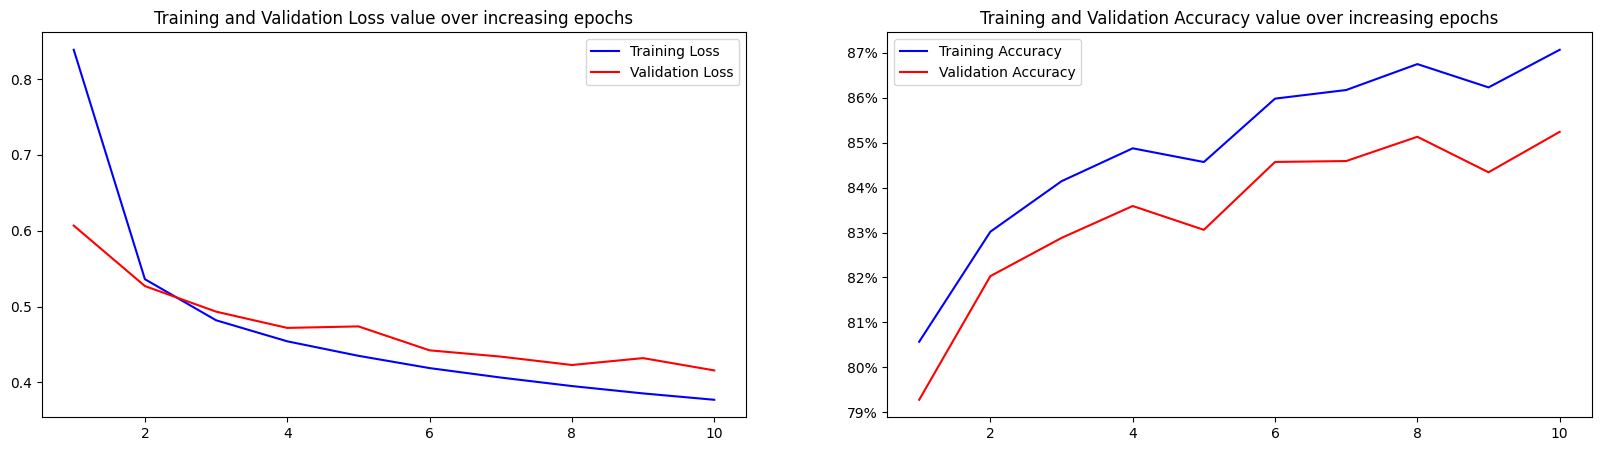

In [131]:
def display_train_validation_results(number_epoch,train_losses, train_accuracies, validation_losses, validation_accuracies):
    epochs = np.arange(number_epoch)+1
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Training and Validation Loss value over increasing epochs')
    plt.plot(epochs, train_losses,'b', label='Training Loss')
    plt.plot(epochs, validation_losses,'r', label='Validation Loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Training and Validation Accuracy value over increasing epochs')
    plt.plot(epochs, train_accuracies,'b', label='Training Accuracy')
    plt.plot(epochs, validation_accuracies,'r', label='Validation Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()

display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

#### Change Batch size from 32 to 10,000

In [132]:
train_data_loader, validation_data_loader = get_data(10000)

In [133]:
model,loss_function, optimizer = build_model()

In [134]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 2.289
Train Accuracy: 21%
Validation Loss: 2.257
Validation Accuracy: 21%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 2.237
Train Accuracy: 25%
Validation Loss: 2.209
Validation Accuracy: 25%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 2.190
Train Accuracy: 33%
Validation Loss: 2.164
Validation Accuracy: 32%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 2.146
Train Accuracy: 40%
Validation Loss: 2.122
Validation Accuracy: 39%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 2.104
Train Accuracy: 47%
Validation Loss: 2.081
Validation Accuracy: 46%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 2.063
Train Accuracy: 54%
Validation Loss: 2.041
Validation Accuracy: 53%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 2.023
Train Accuracy: 59%
Validation Loss: 2.001


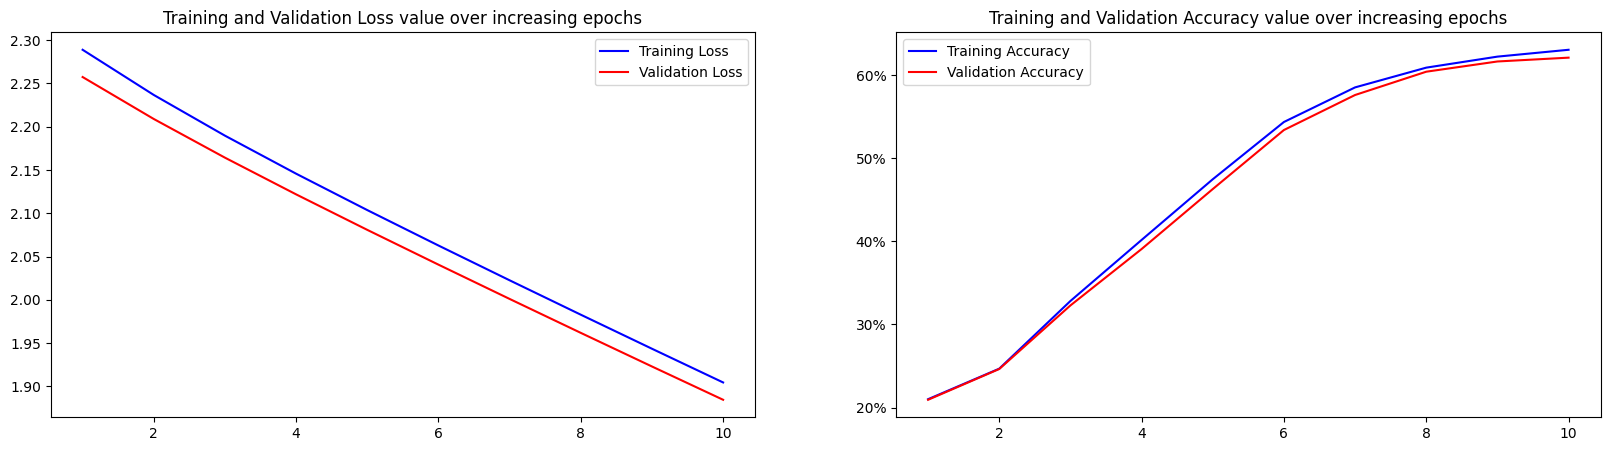

In [135]:
display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

Having a lower batch size generally helps in achieving optimal accuracy when you have a small number of epochs, but it should not be so low that training time is impacted.